In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from sklearn.model_selection import train_test_split

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
TRAIN_DIR = 'Train'
TEST_DIR = 'Test 2'
IMG_SIZE = 224
LR = 0.001
MODEL_NAME = 'Sport-classification-cnn'
def create_label(image_name):
    word_label = image_name[0]
    #print(word_label)
    if word_label == 'B':
        return np.array([1,0,0,0,0,0])
    elif word_label == 'F':
        return np.array([0,1,0,0,0,0])
    elif word_label == 'R':
        return np.array([0,0,1,0,0,0])
    elif word_label == 'S':
        return np.array([0,0,0,1,0,0])
    elif word_label == 'T':
        return np.array([0,0,0,0,1,0])
    elif word_label == 'Y':
        return np.array([0,0,0,0,0,1])

def create_train_data():
    training_data = []
    #print(os.listdir(TRAIN_DIR))
    for img in tqdm(os.listdir(TRAIN_DIR)[1:]):
        path = os.path.join(TRAIN_DIR, img)
        #print(path)
        img_data = cv2.imread(path,0)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img_data), create_label(img)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return np.array(training_data)

def t_data():
    rows=[]
    names=[]
    for img in tqdm(os.listdir(TEST_DIR)[0:]):
        names.append(img)
        path = os.path.join(TEST_DIR, img)
        img_data = cv2.imread(path, 0)
        img_data = cv2.resize(img_data, (IMG_SIZE, IMG_SIZE))
        img_data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        prediction = model.predict([img_data])[0]
        max_value = max(prediction[:].tolist())
        #print(max_value)
        index = prediction[:].tolist().index(max_value)
        rows.append(index)
    dict={"image_name":names,"label":rows}
    df = pd.DataFrame(dict) 
    
    # saving the dataframe 
    df.to_csv('final.csv',index=False) 

In [3]:
if (os.path.exists('train_data.npy')): # If you have already created the dataset:
    train_data =np.load('train_data.npy',allow_pickle=True)
    
else:
    train_data = create_train_data()
    
train = train_data

strat=np.array([i for i in train[:,1]])
#print(train[:,1])
X_train, X_test, y_train, y_test = train_test_split( train[:,0], train[:,1], test_size=0.2,
                                                         random_state=27,stratify=strat)
X_train = np.array([i for i in X_train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
#X_train=X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X_test=np.array([i for i in X_test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array([i for i in y_train]).reshape(X_train.shape[0],6)
y_test = np.array([i for i in y_test]).reshape(X_test.shape[0],6)
#print(X_test.shape,X_train.shape)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from C:\Users\Noha Abdelbary\NN proj\model.tfl
B: 0.00850319117307663, F: 0.00831545703113079,R: 0.009450431913137436, S: 0.14812105894088745,T: 0.04150645062327385, Y: 0.7841033935546875


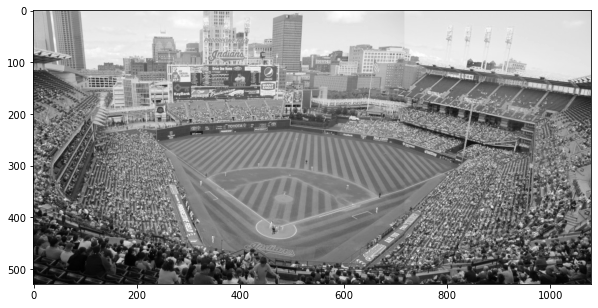

100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [00:01<00:00, 67.81it/s]


In [4]:
tf.compat.v1.reset_default_graph()
conv_input = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
conv1 = conv_2d(conv_input, 32, 5, activation='relu')
pool1 = max_pool_2d(conv1, 5)

conv2 = conv_2d(pool1, 64, 5, activation='relu')
pool2 = max_pool_2d(conv2, 5)

conv3 = conv_2d(pool2, 128, 5, activation='relu')
pool3 = max_pool_2d(conv3, 5)

conv4 = conv_2d(pool3, 64, 5, activation='relu')
pool4 = max_pool_2d(conv4, 5)

conv5 = conv_2d(pool4, 32, 5, activation='relu')
pool5 = max_pool_2d(conv5, 5)

fully_layer = fully_connected(pool5, 1024, activation='relu')
fully_layer = dropout(fully_layer, 0.5)

cnn_layers = fully_connected(fully_layer, 6, activation='softmax')

cnn_layers = regression(cnn_layers, optimizer='adam', loss='categorical_crossentropy', name='targets')
model = tflearn.DNN(cnn_layers, tensorboard_dir='log', tensorboard_verbose=3)
#print (X_train.shape)


if (os.path.exists('model.tfl.meta')):
    model.load('./model.tfl')
else:
    model.fit({'input': X_train}, {'targets': y_train}, n_epoch=100,
              validation_set=({'input': X_test}, {'targets': y_test}),
              snapshot_step=500, show_metric=True, run_id=MODEL_NAME)
    model.save('model.tfl')

img = cv2.imread('Test/3.jpg',0)
test_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
test_img = test_img.reshape(IMG_SIZE, IMG_SIZE, 1)
prediction = model.predict([test_img])[0]
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')
print(f"B: {prediction[0]}, F: {prediction[1]},R: {prediction[2]}, S: {prediction[3]},T: {prediction[4]}, Y: {prediction[5]}")
plt.show()
t_data()

